<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part10/P10_CH01_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNetV3을 이용한 Image Classification 구현 및 성능 개선


## Data 소개
- 이번 주제는 Intel image classification dataset을 사용합니다.
- Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
- 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
- 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

1. seg_train
  - training용 data

2. seg_test
  - validation용 data로 사용
  - label 있음
  

3. set_pred
  - test용 data
  - label 없음
  - 미사용

원본 데이터 출처 https://www.kaggle.com/datasets/puneet6060/intel-image-classification
  

In [1]:
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from keras.applications import *
from keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
## Hyper Parameter 설정

# image resolution
RES = 224

# class 수
N_CLASS = 6

# Batch Size
N_BATCH = 64

# Epoch 수
N_EPOCH = 50

# Learning rate
LR = 0.0001

# 1. Data Download / Preprocessing

## Data 불러오기

In [3]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [4]:
gdown.download(data_url, 'intel_image_classification.tar', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
100%|██████████| 388M/388M [00:05<00:00, 65.5MB/s]


'intel_image_classification.tar'

In [5]:
!tar -xf intel_image_classification.tar

In [7]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [8]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


## Dataset 만들기


In [9]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(RES, RES),
    batch_size=N_BATCH,
    shuffle = True
    )

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(RES, RES),
    batch_size=N_BATCH,
    shuffle = False
    )

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## 데이터 개수 확인

In [10]:
N_TRAIN = 14034
N_VAL = 3000

## Class list 만들기

In [11]:
# classes = ['buildings', 'forest', 'mountains', 'glacier', 'sea', 'street']
classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [12]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

## Dataset 확인하기

images.shape (64, 224, 224, 3)
labels.shape (64,)
images.dtype <dtype: 'float32'>
labels.dtype <dtype: 'int32'>


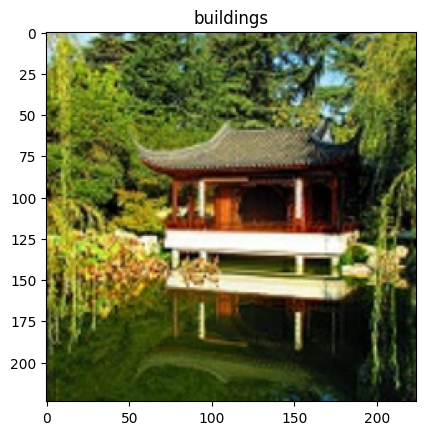

In [13]:
for images, labels in train_ds.take(1):
    print('images.shape', images.shape)
    print('labels.shape', labels.shape)
    print('images.dtype', images.dtype)
    print('labels.dtype', labels.dtype)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(classes[labels[0].numpy()])
    plt.show( )

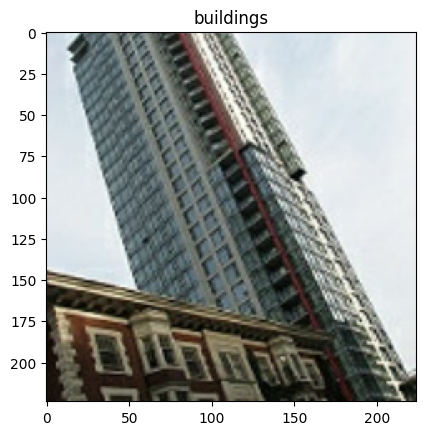

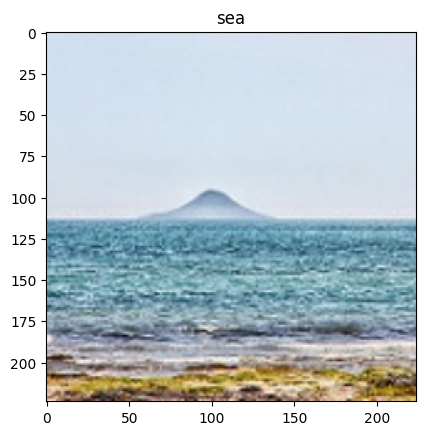

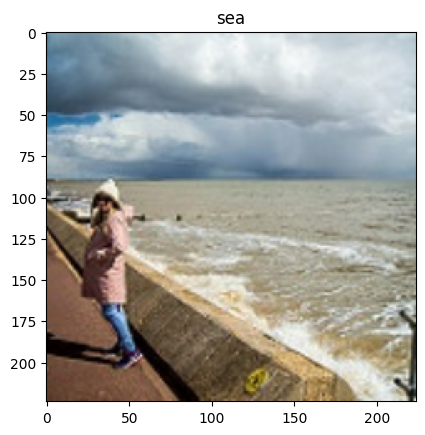

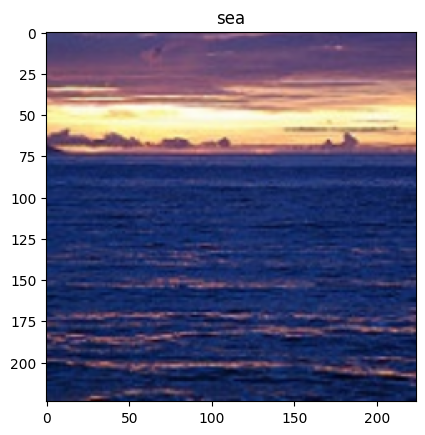

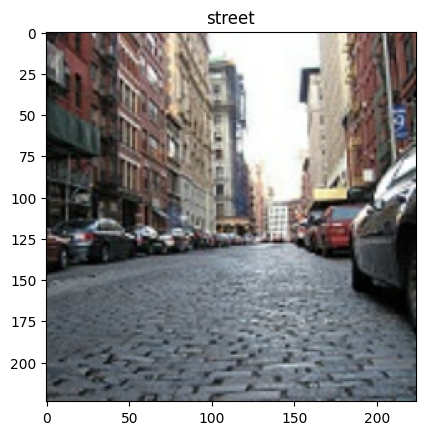

In [14]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(classes[labels[0].numpy()])
    plt.show( )

# 2. Pretrained MobileNetV3 로 Training 하기

In [15]:
from keras.applications import MobileNetV3Small
from keras.applications.mobilenet_v3 import preprocess_input

mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

4334752/4334752 [==============================] - 1s 0us/step


In [16]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [17]:
def create_model():
    inputs = keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outputs = Softmax()(x)

    model = keras.Model(inputs, outputs)
    return model

In [18]:
model = create_model()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3462      
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                             

## 학습

In [20]:
model.compile(keras.optimizers.SGD(learning_rate=LR), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [21]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 54s 143ms/step - loss: 1.8837 - accuracy: 0.2339 - val_loss: 2.0321 - val_accuracy: 0.2427
Epoch 2/50
220/220 [==============================] - 29s 130ms/step - loss: 1.6835 - accuracy: 0.3140 - val_loss: 1.8216 - val_accuracy: 0.3007
Epoch 3/50
220/220 [==============================] - 27s 123ms/step - loss: 1.5264 - accuracy: 0.3834 - val_loss: 1.6114 - val_accuracy: 0.3663
Epoch 4/50
220/220 [==============================] - 29s 130ms/step - loss: 1.4098 - accuracy: 0.4485 - val_loss: 1.4532 - val_accuracy: 0.4293
Epoch 5/50
220/220 [==============================] - 28s 125ms/step - loss: 1.3257 - accuracy: 0.4957 - val_loss: 1.3366 - val_accuracy: 0.4887
Epoch 6/50
220/220 [==============================] - 29s 131ms/step - loss: 1.2576 - accuracy: 0.5352 - val_loss: 1.2485 - val_accuracy: 0.5340
Epoch 7/50
220/220 [==============================] - 27s 122ms/step - loss: 1.2056 - accuracy: 0.5637 - val_loss: 1.1840 - val_ac

## Optimizer 변경해보기

In [24]:
model2 = create_model()
model2.compile(keras.optimizers.Adam(learning_rate=LR), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [25]:
model2.fit(train_ds, epochs = N_EPOCH, validation_data = val_ds)

Epoch 1/50
220/220 [==============================] - 55s 132ms/step - loss: 0.7690 - accuracy: 0.8082 - val_loss: 0.5125 - val_accuracy: 0.9057
Epoch 2/50
220/220 [==============================] - 30s 134ms/step - loss: 0.5069 - accuracy: 0.9181 - val_loss: 0.5483 - val_accuracy: 0.9147
Epoch 3/50
220/220 [==============================] - 31s 138ms/step - loss: 0.4491 - accuracy: 0.9305 - val_loss: 0.5460 - val_accuracy: 0.9187
Epoch 4/50
220/220 [==============================] - 28s 125ms/step - loss: 0.4110 - accuracy: 0.9416 - val_loss: 0.5462 - val_accuracy: 0.9183
Epoch 5/50
220/220 [==============================] - 29s 130ms/step - loss: 0.3824 - accuracy: 0.9484 - val_loss: 0.5424 - val_accuracy: 0.9097
Epoch 6/50
220/220 [==============================] - 28s 127ms/step - loss: 0.3510 - accuracy: 0.9617 - val_loss: 0.5025 - val_accuracy: 0.9230
Epoch 7/50
220/220 [==============================] - 28s 127ms/step - loss: 0.3274 - accuracy: 0.9674 - val_loss: 0.4860 - val_ac

KeyboardInterrupt: ignored

- adam의 정확도가 훨씬 높음, SGD에는 모멘텀 설정해서 성능향상가능